<a href="https://colab.research.google.com/github/halizz821/AE_dimension_reduction/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mountin Google Drive

In [1]:
####### Mounting your google drive
from google.colab import drive
drive.mount('/content/drive')

####### Data address in google drive
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning-FeatureExtraction

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/DeepLearning-FeatureExtraction


# Import Libraries

In [2]:
!pip install earthpy

import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

seed(11)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 38.9 MB/s eta 0:00:00


# Load Data

In [3]:
################## Load Hyperspectral image
data = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected'].astype(np.float16)


###################### Load Ground Truth image
# gt = loadmat('Pavia_gt.mat')['pavia_gt']

print(f'Image Shape: {data.shape[:-1]}\nNumber of Spectral bands: {data.shape[-1]}')

Image Shape: (145, 145)
Number of Spectral bands: 200


# Data Visualization

*This section of code is not necessary and you can skip it. It just visuallizes some spectral bands of the input image to get familiar with your data*

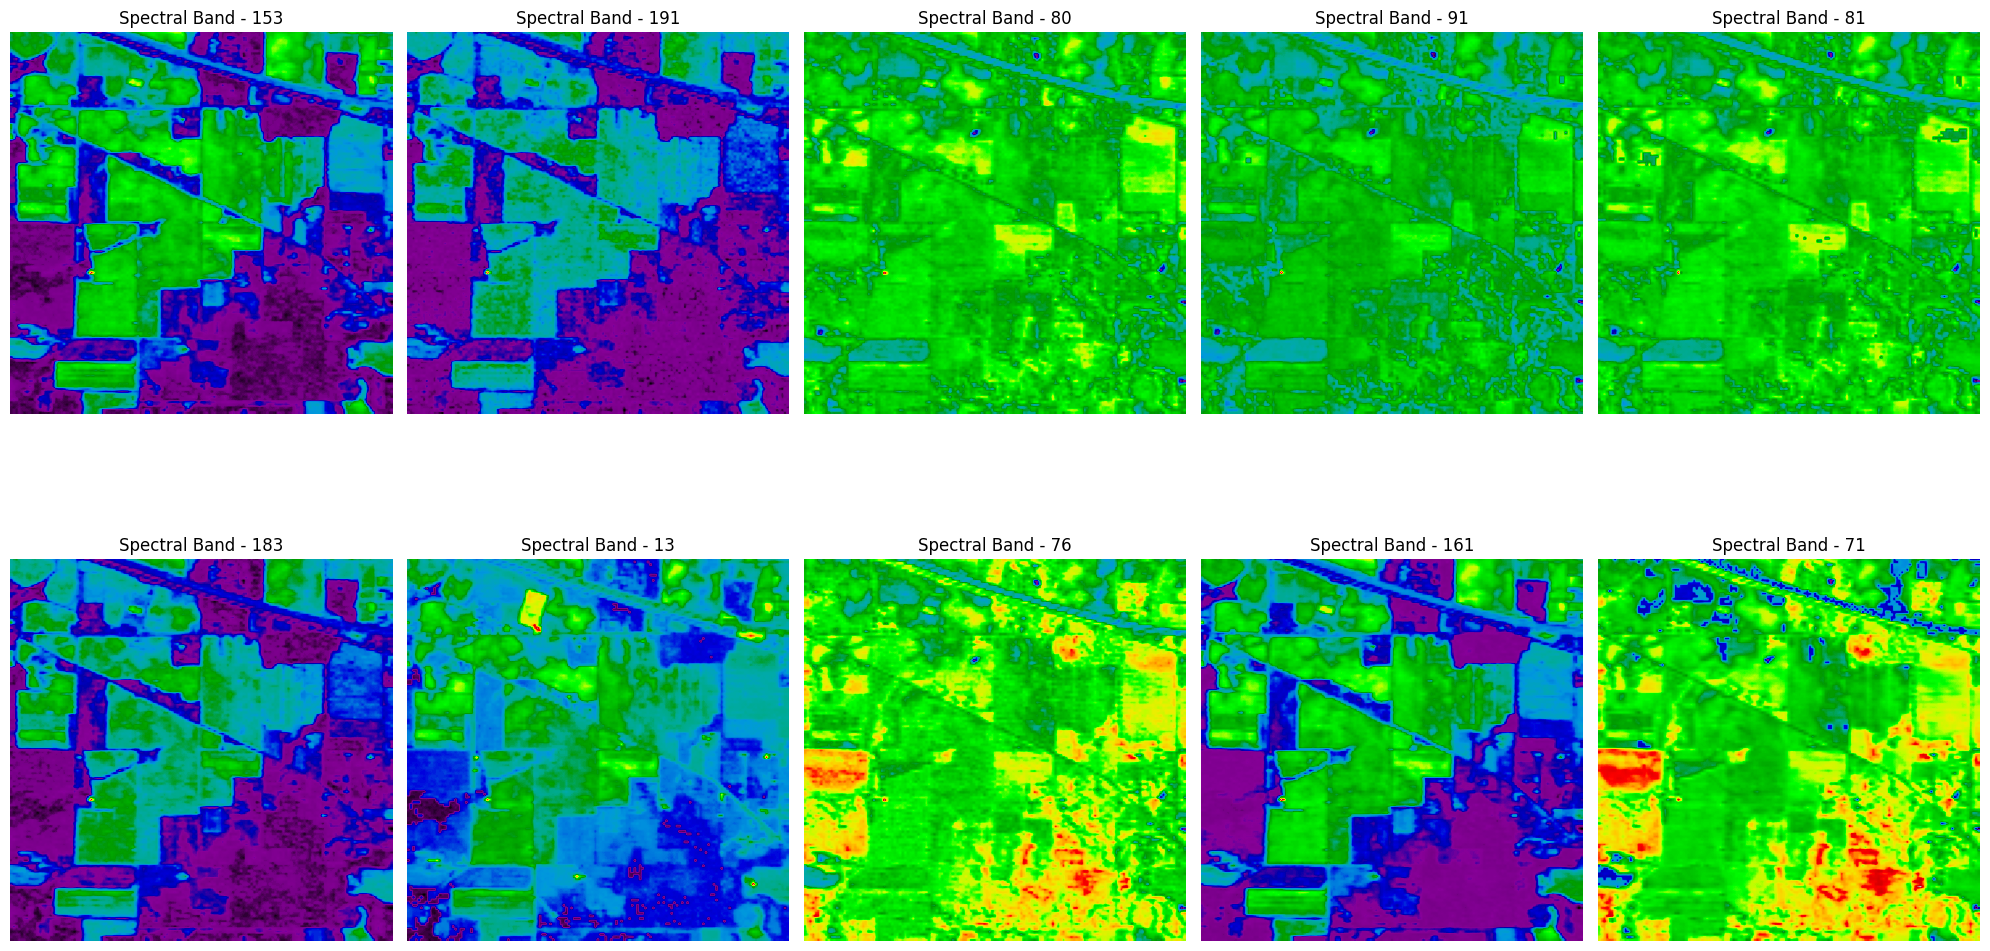

In [4]:
fig = plt.figure(figsize = (20, 12))  # open a figure

ax = fig.subplots(2, 5) # divide the figure into several subfigures

##### plot each subplot
for i in range(2):
  for j in range(5):
    c = np.random.randint(data.shape[2]) ### randomely select a spectral band
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Spectral Band - {c}") # title
    c+=1

plt.tight_layout()
plt.show()


# RGB Composite Visualization

*This section of code is not necessary and you can skip it. It just visuallizes an RGB color composite of the input image to get familiar with your data*

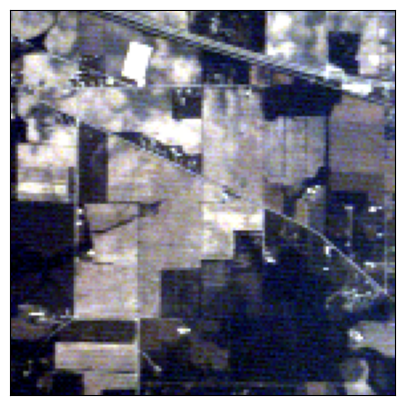

In [7]:
mdata = np.moveaxis(data, -1, 0) # becauase mdata in ep.plot_rgb shoould be An n-dimensional array in rasterio band order (bands, rows, columns) containing the layers to plot.
R=10 # Red spectral band number
G=5 # Green spectral band number
B=2  # Blue spectral band number
ep.plot_rgb(mdata, (R,G,B), figsize=(5, 5),stretch=True)  # Plot red, green, and blue bands, respectively

plt.show()

# Pre-processing
This step includes:

  1) Scaling samples to [0,1] interval
  
  2) Split samples into training, validation and test samples


In [8]:
################ Scaling

def ScaleData(X,min_value,max_value):
  #This function sclae the data 'X' between 0 and 1
  X -= min_value
  X /= (max_value - min_value)
  return X

row,col,band=data.shape
samples=data.reshape(-1,band)

# Find the minimum and maximum values of the array
min_value = np.min(samples)
max_value = np.max(samples)

# Scale the array between 0 and 1
samples=ScaleData(samples,min_value,max_value)

################# Split samples into: 1) Training, 2) Validation



X_train, X_val = train_test_split(samples,train_size=0.7)


print(f"X_train: {X_train.shape}\nX_validation: {X_val.shape}")






X_train: (14717, 200)
X_validation: (6308, 200)


# Build AutoEncoder

In [9]:
ip_shape = X_train.shape[1] # input shape of model

input_img = keras.Input(shape=(ip_shape,))
encoded = keras.layers.Dense(128, activation='LeakyReLU')(input_img)
encoded = keras.layers.Dense(64, activation='LeakyReLU')(encoded)
encoded = keras.layers.Dense(32, activation='LeakyReLU')(encoded)

encoded = keras.layers.Dense(18, activation='LeakyReLU',name='last_encod')(encoded) # 18 will be the new dimension of input image

decoded = keras.layers.Dense(32, activation='LeakyReLU')(encoded)
decoded = keras.layers.Dense(64, activation='LeakyReLU')(decoded)
decoded = keras.layers.Dense(128, activation='LeakyReLU')(decoded)
decoded = keras.layers.Dense(ip_shape, activation='sigmoid')(decoded)


autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 last_encod (Dense)          (None, 18)                594       
                                                                 
 dense_3 (Dense)             (None, 32)                608       
                                                                 
 dense_4 (Dense)             (None, 64)                2112  

# Train model

In [13]:
######## compiling the model
autoencoder.compile(optimizer='adam', loss='MeanSquaredError', metrics=['accuracy'])

######## define calback of the model
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0.0001,
                            patience = 5,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'AE_Model.h5',
                             monitor = 'val_loss',
                             mode ='min',
                             save_best_only = True) # save the model with the best loss performance on validation data

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

########## Fit the model on training samples

hist = autoencoder.fit(X_train, X_train,
                        epochs=100,#No of epochs
                        batch_size=64,# batch size
                        shuffle=True,
                        validation_data=(X_val, X_val),  # validation data
                        callbacks=[early_stop,
                                  checkpoint,
                                  tensorboard])



Epoch 1/100
230/230 [==============================] - 25s 49ms/step - loss: 2.8158e-04 - accuracy: 0.8718 - val_loss: 1.8226e-04 - val_accuracy: 0.8987
Epoch 2/100
230/230 [==============================] - 6s 25ms/step - loss: 1.7767e-04 - accuracy: 0.8878 - val_loss: 1.7076e-04 - val_accuracy: 0.8946
Epoch 3/100
230/230 [==============================] - 3s 15ms/step - loss: 1.6763e-04 - accuracy: 0.8825 - val_loss: 1.6481e-04 - val_accuracy: 0.8946
Epoch 4/100
230/230 [==============================] - 3s 15ms/step - loss: 1.6197e-04 - accuracy: 0.8842 - val_loss: 1.5052e-04 - val_accuracy: 0.8947
Epoch 5/100
230/230 [==============================] - 4s 17ms/step - loss: 1.5698e-04 - accuracy: 0.8882 - val_loss: 1.4882e-04 - val_accuracy: 0.8960
Epoch 6/100
230/230 [==============================] - 3s 15ms/step - loss: 1.4819e-04 - accuracy: 0.8877 - val_loss: 1.5832e-04 - val_accuracy: 0.8916


# Plot results (loss and accuracy) of all epochs

In [14]:
hist2 = pd.DataFrame(data= hist.history)

fig = go.Figure()

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.loss.values,
                    mode='lines+markers',
                    name='Train Loss'))

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.accuracy.values,
                    mode='lines+markers',
                    name='Train Accuracy'))

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.val_loss.values,
                    mode='lines+markers', name='Test loss'))

fig.add_trace(go.Scatter(x = hist2.index, y = hist2.val_accuracy.values,
                    mode='lines+markers', name='Test Accuracy'))

fig.show()

# Dimension reduction of whole image

In [16]:
from keras.models import Model,load_model

######## load the model with the best performance on validation samples
autoencoder = load_model("AE_Model.h5") # loading the model with the best validation metric

# Create a new model that outputs the last encoder layer's output for dimension reduction
encoder_output_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('last_encod').output)

encoder_output = encoder_output_model.predict(samples)

reduced_image=encoder_output.reshape(row,col,-1)  # dimensionality reduced image


658/658 [==============================] - 8s 11ms/step


# Display the dimensionality reduced image

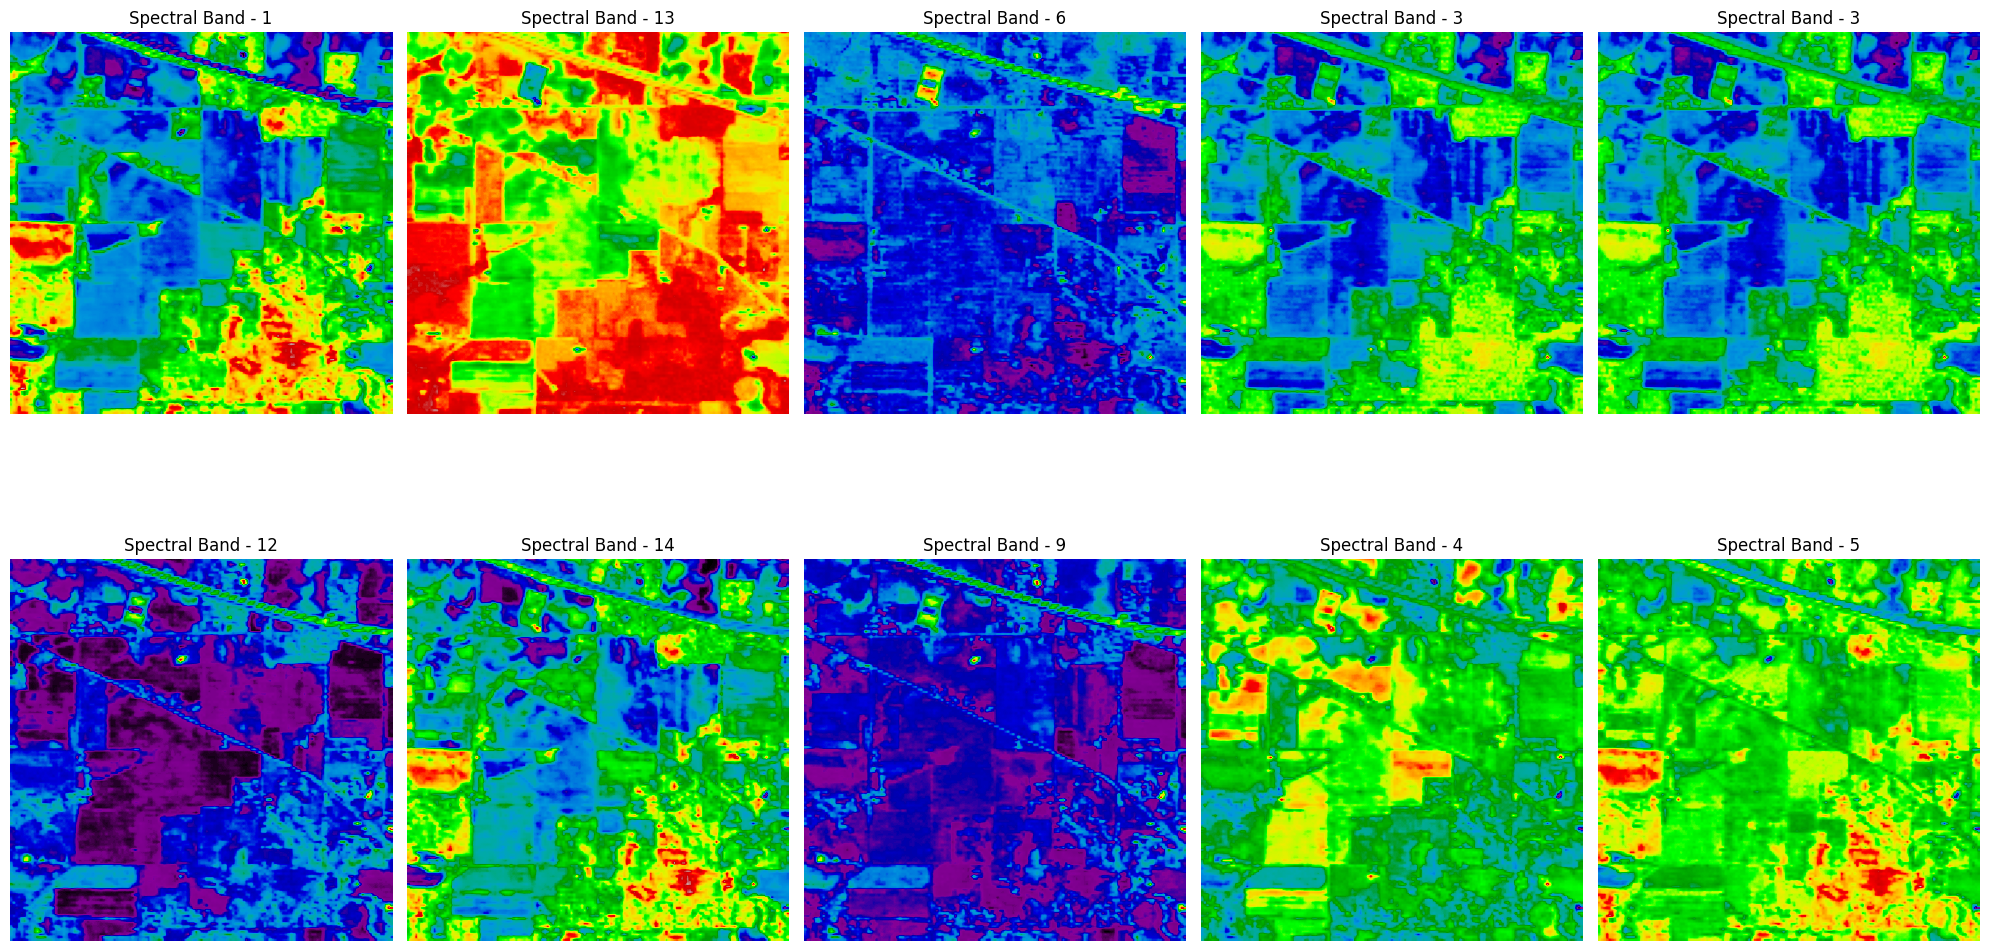

In [17]:
fig = plt.figure(figsize = (20, 12))  # open a figure

ax = fig.subplots(2, 5) # divide the figure into several subfigures

##### plot each subplot
for i in range(2):
  for j in range(5):
    c = np.random.randint(reduced_image.shape[2]) ### randomely select a spectral band
    ax[i][j].imshow(reduced_image[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Spectral Band - {c}") # title
    c+=1

plt.tight_layout()
plt.show()